# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in Varusai and Nguyen, 2018.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement

The biological problem we address is controlling the concentration of phosphorylated mTORC1 and mTORC2 through insulin. \ccite{varusai_dynamic_2018} describe this in terms of the parameter V1, the rate of activation of the insulin receptor. We do the same. So, the system we study has the single input $V1$ and the outputs mTORC1, mTORC2. It turns out that the mTOR system is bistable with respect to the insulin. Thus, our control objective is to regulate the outputs in the high insulin region where V1 $> 4$.
* Outputs: pmTORC1, pmTORC2
* Inputs: V1
* Control problem: regulate pmTORC1, pmTORC2

## mTOR Model

In [7]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
MTOR_CTLSB = ctl.ControlSBML(MTOR_URL, input_names=["V1"], output_names=["pmTORC1", "pmTORC2"])
MTOR_BUILDER = MTOR_CTLSB.makeMIMOTransferFunctionBuilder(is_fixed_input_species=False)
MTOR_MODEL = MTOR_CTLSB.antimony
print(MTOR_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

# System Identification

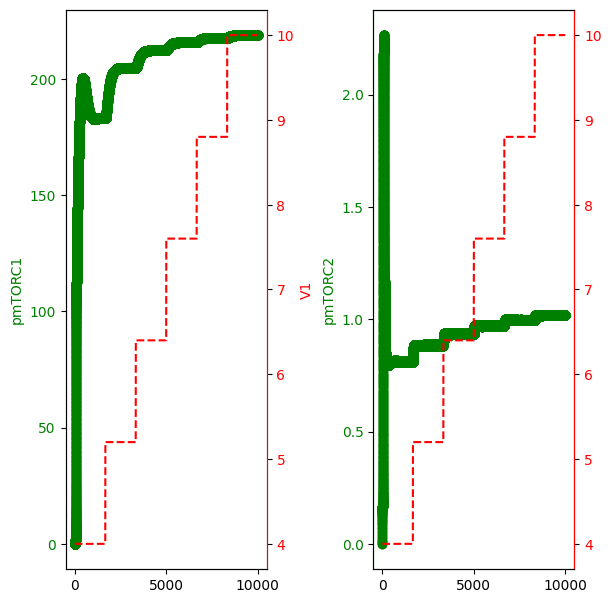

Outputs,pmTORC1,pmTORC2
Inputs,,
V1,,


In [8]:
MTOR_STAIRCASE = ctl.Staircase(initial_value=4, final_value=10, num_step=5)
response_ts = MTOR_BUILDER.makeStaircaseResponse(staircase=MTOR_STAIRCASE, end_time=10000)
_ = MTOR_BUILDER.plotStaircaseResponse(response_ts,  figsize=(6,6), legend_crd=(2, 1))

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

In [ ]:
fitter_result = MTOR_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, staircase=MTOR_STAIRCASE, fit_start_time=3500, start_time=0, end_time=10000)
MTOR_BUILDER.plotFitTransferFunction(fitter_result)

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [41]:
siso = ctl.SISOClosedLoopSystem(MTOR_CTLSB)
siso.makePIDClosedLoopSystem(kp=2, ki=0.5)

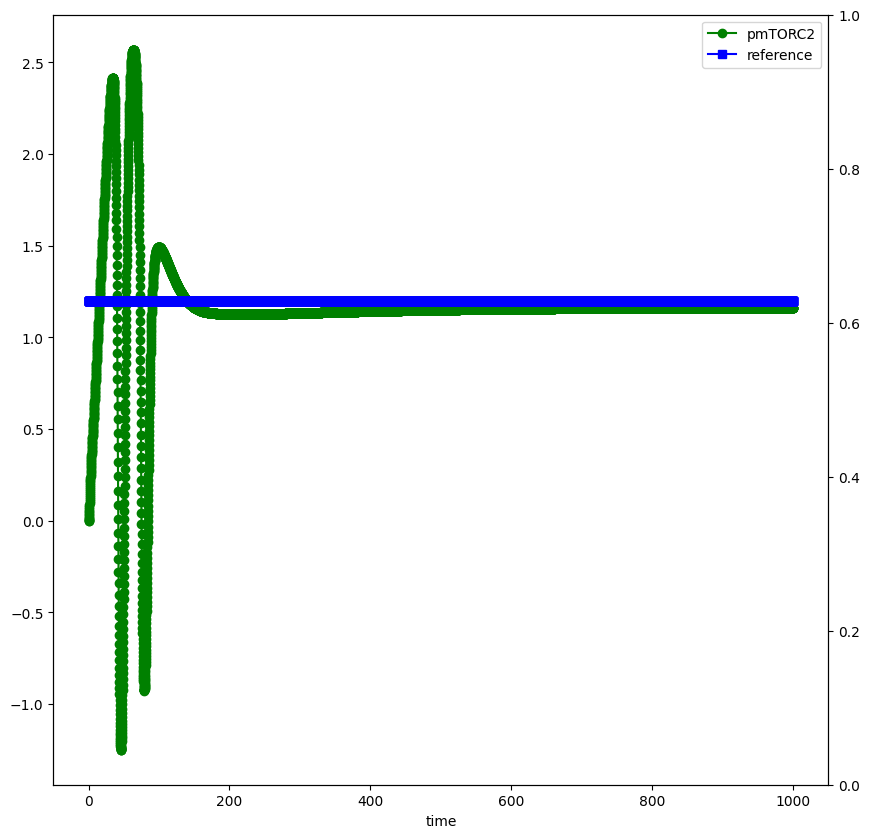

In [43]:
result_ts = siso.makeStepResponse(start_time=0, end_time=1000, step_size=1.2)
ctl.plotOneTS(result_ts)